In [1]:
!pip install datasets
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.3 MB/s eta 0:00:00a 0:00:01


In [2]:
import pandas as pd
import numpy as np
import random
import torch
import transformers
import torch.nn as nn
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from datasets import load_metric, Dataset
from sklearn.metrics import classification_report, f1_score
import torch.nn.functional as F

tqdm.pandas()

device = torch.device('cuda') # !!!!!!!!!!!!

In [3]:
train_df = pd.read_excel('/kaggle/input/mail-news-data/data.mail.xlsx', 
                         engine = 'openpyxl', 
                         index_col = 0, 
                         sheet_name=['kino.mail', 'health.mail', 'dom.mail', 'deti.mail'], nrows=6000)

In [4]:
train_df = pd.concat(train_df).reset_index(drop=True)
train_df['Keywords'].value_counts().head(10)

Keywords
НОВОСТЬ              4009
Интерьеры            2346
Семья                1851
Город                1349
Питание              1190
Дети 3-7 лет         1146
Лайфхаки              871
Дети старше 7 лет     687
Жизнь за городом      659
Беременность          603
Name: count, dtype: int64

In [5]:
data2 = pd.read_excel('/kaggle/input/mail-news-data/output.xlsx', engine='openpyxl', nrows=6000)
data2['Keywords'].value_counts().head(10)

/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Keywords
Светская жизнь               1573
Новости                       917
Красота                       380
Мода                          295
Отношения                     148
Tengrinews, Новости           119
История успеха                104
Comode.kz, Новости             91
7 дней, Светская жизнь         79
pret-a-portal.by, Новости      71
Name: count, dtype: int64

In [6]:
data_sport = pd.read_excel('/kaggle/input/mail-news-data/sport.xlsx', engine='openpyxl', nrows=6000)
data_sport['Keywords'].value_counts().head(10)

/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Keywords
-    4910
Name: count, dtype: int64

In [7]:
data_gen_news = pd.read_excel('/kaggle/input/mail-news-data/general_news2.xlsx', engine='openpyxl', nrows=10000)
print(data_gen_news['Keywords'].value_counts().head(10))

# data_gen_news1 = data_gen_news1[data_gen_news1.Keywords == 'Политика']
# data_gen_news1 = data_gen_news1[data_gen_news1.Keywords == 'Экономика']

Keywords
Общество     4755
События      2564
Политика     1576
Экономика    1013
-              83
Name: count, dtype: int64


In [ ]:
# train_df.drop(['Title', 'Description', 'Keywords'], axis=1, inplace=True)
# data2.drop(['Title', 'Description', 'Keywords'], axis=1, inplace=True)
# data_sport.drop(['URL', 'Title', 'Description', 'Keywords'], axis=1, inplace=True)
# data_gen_news.drop(['URL', 'Title', 'Description', 'Keywords'], axis=1, inplace=True)

In [8]:
data_gen_news.fillna('', inplace=True)
data_gen_news.isna().sum()

URL             0
Title           0
Description     0
Article Text    0
Keywords        0
dtype: int64

In [9]:
train_df = pd.concat([train_df, data2, data_sport, data_gen_news]);

In [10]:
train_df['Keywords'].value_counts().head(20)

Keywords
-                    4993
Общество             4755
НОВОСТЬ              4009
События              2564
Интерьеры            2346
Семья                1851
Политика             1576
Светская жизнь       1573
Город                1349
Питание              1190
Дети 3-7 лет         1146
Экономика            1013
Новости               917
Лайфхаки              871
Дети старше 7 лет     687
Жизнь за городом      659
Беременность          603
1 год - 3 года        490
Квартира дня          459
Происшествия          452
Name: count, dtype: int64

In [11]:
from datasets import Dataset

news_dataset = Dataset.from_pandas(train_df)
news_dataset

Dataset({
    features: ['Title', 'Description', 'Article Text', 'Keywords', 'URL', '__index_level_0__'],
    num_rows: 42934
})

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
# model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')
# model.to(device)

In [12]:
# !!!!!
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/distiluse-base-multilingual-cased-v1')
model = AutoModel.from_pretrained('sentence-transformers/distiluse-base-multilingual-cased-v1')
model.to(device)

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [13]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [15]:
def get_embeddings(text_list):
    encoded_input = tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings

In [16]:
embeddings_dataset = news_dataset.map(
    lambda x: {"embeddings": get_embeddings(x["Article Text"]).detach().cpu().numpy()[0]}
)

Map:   0%|          | 0/42934 [00:00<?, ? examples/s]

In [17]:
!pip install faiss-gpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
embeddings_dataset.add_faiss_index(column="embeddings")

  0%|          | 0/43 [00:00<?, ?it/s]

Dataset({
    features: ['Title', 'Description', 'Article Text', 'Keywords', 'URL', '__index_level_0__', 'embeddings'],
    num_rows: 42934
})

2024-05-21 15:31:43.140285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 15:31:43.140409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 15:31:43.265327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


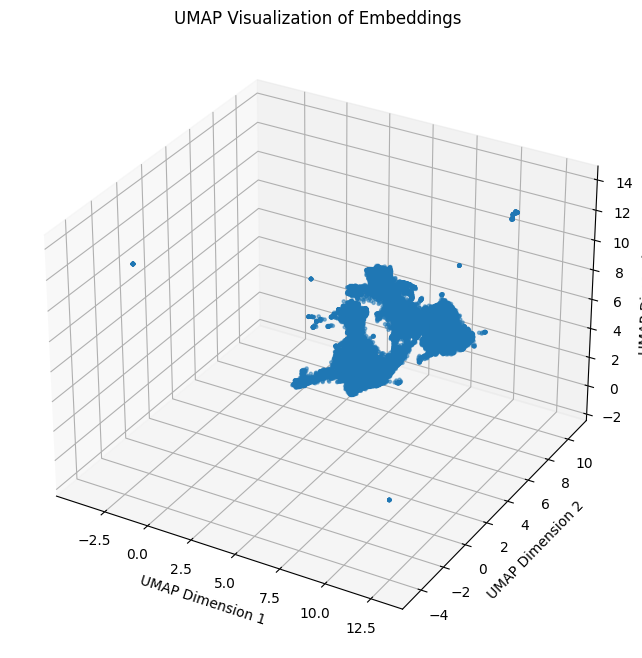

In [19]:
import umap
import matplotlib.pyplot as plt

# Предполагается, что у вас есть датасет embeddings_dataset с колонками "embeddings"
# embeddings_dataset.add_faiss_index(column="embeddings")

# Получение эмбеддингов из датасета
embeddings = np.array(embeddings_dataset["embeddings"])

# Построение UMAP с тремя размерностями
umap_model = umap.UMAP(n_components=4)
embedding_umap = umap_model.fit_transform(embeddings)

# Визуализация
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding_umap[:, 0], embedding_umap[:, 1], embedding_umap[:, 2], s=5, alpha=0.5)
ax.set_title('UMAP Visualization of Embeddings')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')
plt.show()

In [20]:
import pandas as pd
from sklearn.cluster import KMeans

# Предполагается, что вы уже загрузили ваш датасет embeddings_dataset

# Определяем количество кластеров
num_clusters = 15 # !!!!!!!!!!!!!!

# Создаем объект KMeans
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)

# Обучаем модель на эмбеддингах
kmeans.fit(embeddings_dataset["embeddings"])

# Получаем метки кластеров для каждого эмбеддинга
cluster_labels = kmeans.labels_


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
embeddings_dataset = embeddings_dataset.to_pandas()

In [22]:
embeddings_dataset["cluster_label"] = cluster_labels

# Создаем пустой словарь для хранения текстов для каждого центроида
centroid_texts = {i: [] for i in range(num_clusters)}

# Находим ближайшие тексты для каждого центроида
for i, centroid in enumerate(kmeans.cluster_centers_):
    centroid_index = embeddings_dataset[embeddings_dataset["cluster_label"] == i].index
    centroid_embeddings = embeddings_dataset.loc[centroid_index, "embeddings"].tolist()

    # Вычисляем расстояния между текущим центроидом и всеми эмбеддингами кластера
    distances = [np.linalg.norm(centroid - emb) for emb in centroid_embeddings]

    # Находим индексы пяти ближайших текстов к центроиду
    closest_texts_index = np.argsort(distances)[:10]

    # Получаем тексты и добавляем их в словарь
    closest_texts = embeddings_dataset.loc[centroid_index[closest_texts_index], "Article Text"].tolist()
    centroid_texts[i] = closest_texts

# Выводим тексты для каждого центроида
for cluster, texts in centroid_texts.items():
    print(f"Cluster {cluster}:")
    for text in texts:
        print(text)
        print()
    print()

Cluster 0:
«Почти полмиллиона человек встретили Новый год на центральных площадках в каждом округе столицы», — написал градоначальник. Согласно данным Собянина, торжественная программа затронула 21 московский парк и 12 окружных площадок. «Традиционно одной из главных стала ВДНХ», — отметил мэр. Он рассказал, что там гостям праздника продемонстрировали ледовое шоу и спектакли о символах-покровителях наступившего года. На территории остальных городских площадок тоже состоялись концерты, световые шоу и театральные постановки. «До 3 часов ночи работали 26 площадок “Путешествие в Рождество”, — подытожил глава столицы. До этого стало известно, что новогодние мероприятия 31 декабря на международной выставке-форуме «Россия» посетили более 120 тысяч человек из 89 регионов России. Для них куранты били 11 раз — по количеству часовых поясов в РФ.   

«Прекрасный лед, сделанный нашими спортсменами, уже ждет новосибирцев», — сказала Анна Терешкова. Каток доступен для посещения ежедневно с 12:00 до 2

In [ ]:
import joblib

# Сохранение модели K-means в файл
# joblib.dump(kmeans, 'kmeans_12_clusters_new_model.pkl')

In [ ]:
# loaded_kmeans = joblib.load('/kaggle/input/mail-news-data/kmeans_15_clusterss_2005.pkl')

In [23]:
# kmeans = loaded_kmeans

def get_embeddings(text_list):
    encoded_input = tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings

def predict(embedding):
    cluster_labels = kmeans.predict(list(embedding.cpu().detach().numpy()))
    return cluster_labels[0]

text = "«По-видимому, (ВСУ. — Прим. ред.) приходится отводить войска из горячих точек — из Артемовска и Авдеевки — и отправлять их на север. Это ослабляет южный фронт», — считает офицер.\nПо мнению генерала, переброска частей ВСУ из-под Часова Яра и Авдеевки соответствует стратегическому замыслу российского командования. Ришу предполагает, что ВС России хотят выманить резервы украинской армии и уничтожить их.\nНакануне глава ГУР Минобороны Украины Кирилл Буданов*, заявил, что ситуация для Вооруженных сил Украины в Харьковской области становится критической. Он также сообщил, что Киеву будет сложно перенаправить украинские части к Харьковской области, поскольку они сконцентрированы в других районах.\nВ понедельник в Минобороны сообщили, что российские военнослужащие освободили Гатище, Красное, Мороховец и Олейниково в Харьковской области."
embedding = get_embeddings(text)
class_label = predict(embedding)
class_label

12

In [ ]:
from scipy.spatial.distance import cdist
def predict_cluster_proba(text, get_embeddings, kmeans_mod):
    # Получаем эмбеддинг текста
    text_embedding = get_embeddings(text)
    
    # Переносим тензор на CPU и преобразуем в numpy
    text_embedding = text_embedding.cpu().numpy().astype('float64')
    
    # Предсказываем кластер
    cluster = kmeans_mod.predict(text_embedding.reshape(1, -1))[0]
    
    # Вычисляем расстояния от текста до каждого центроида
    distances = cdist(text_embedding.reshape(1, -1), kmeans_mod.cluster_centers_, 'minkowski')[0]
    
    # Преобразуем расстояния в "вероятности", используя softmax
    probabilities = np.exp(-distances) / np.sum(np.exp(-distances))
    
    return cluster, probabilities

In [24]:
def process_list(input_list):
    input_list = list(input_list)
    max_value = max(input_list)
    max_index = input_list.index(max_value)

    indexes = set()

    result = [(max_index, max_value)]
    indexes.add(max_index)

    for i, value in enumerate(input_list):
        if ((max_value > 0.071 and 0.07 < value and value >= max_value - 0.0008) or
            value >= max_value - 0.0008) and i not in indexes:
            result.append((i, value))
            indexes.add(i)

    for i, value in enumerate(input_list):
        if value > 0.072 and i not in indexes:
            result.append((i, value))
            indexes.add(i)

    return result

In [25]:
text = 'Компания Amazon анонсировала продолжение боевика «Дом у дороги», который стал хитом стрим-сервиса Prime Video. Джейк Джилленхол в предстоящем сиквеле вернется к роли Элвуда Далтона. Больше никаких сведений о проекте на данный момент нет. Глава Amazon MGM Studio Дженнифер Салке заявила:\n«Как мы увидели этой весной, мир сошел с ума из-за маленького фильма под названием «Дом у дороги».\nПо данным Amazon, фильм привлек на данный момент 80 млн зрителей. Премьера на стриминге состоялась 21 марта. Впрочем, к этой цифре стоит подходить осторожно, поскольку Amazon не уточняет, что именно засчитывается как «просмотр». Несмотря на это, тот факт, что компания дала зеленый свет сиквелу, указывает на прибыльность проекта.\n«Дом у дороги» является ремейком одноименного боевика с Патриком Суэйзи, который вышел в 1989 году. В новом фильме антагониста воплотил Конор Макгрегор, дебютировавший в кино. Сценарий написали Энтони Багароцци и Чак Мондри. Снял фильм именитый режиссер Даг Лайман («Грань будущего», «Идентификация Борна»). В актерский состав также вошли Даниэла Мелшиор, Джессика Уильямс, Билли Магнуссен, Жоакин де Алмейда и Лукас Гейдж.'
cluster, probs = predict_cluster_proba(text, get_embeddings, kmeans)
print(cluster, probs)
process_list(probs)

NameError: name 'predict_cluster_proba' is not defined

/opt/conda/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


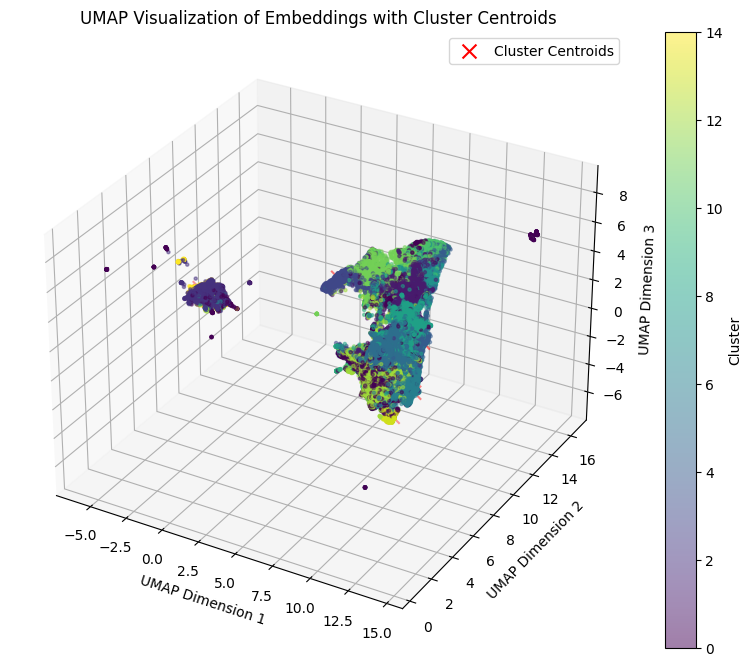

In [26]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Построение UMAP с тремя размерностями
umap_model = umap.UMAP(n_components=3)
embedding_umap = umap_model.fit_transform(embeddings)

# Визуализация
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding_umap[:, 0], embedding_umap[:, 1], embedding_umap[:, 2], c=cluster_labels, cmap='viridis', s=5, alpha=0.5)
plt.colorbar(scatter, ax=ax, label='Cluster')
ax.set_title('UMAP Visualization of Embeddings with Cluster Centroids')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')

# Отмечаем центроиды кластеров
centroids_umap = umap_model.transform(kmeans.cluster_centers_)
ax.scatter(centroids_umap[:, 0], centroids_umap[:, 1], centroids_umap[:, 2], marker='x', c='red', s=100, label='Cluster Centroids')

plt.legend()
plt.show()

In [30]:
!pip install urbangrammar-graphics
!pip install clustergram

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

sns.set(style='whitegrid')

In [ ]:
data = scale(embeddings_dataset["embeddings"].to_list())
# data = embeddings_dataset["embeddings"]

cgram = Clustergram(range(1, 16), n_init=200)
cgram.fit(data)

K=1 skipped. Mean computed from data directly.
K=2 fitted in 188.665 seconds.
K=3 fitted in 199.424 seconds.
K=4 fitted in 201.296 seconds.
K=5 fitted in 332.431 seconds.
K=6 fitted in 334.176 seconds.
K=7 fitted in 450.996 seconds.
K=8 fitted in 465.601 seconds.
K=9 fitted in 622.746 seconds.
K=10 fitted in 960.452 seconds.
K=11 fitted in 996.851 seconds.
K=12 fitted in 917.368 seconds.
K=13 fitted in 1055.843 seconds.
K=14 fitted in 1040.773 seconds.


In [ ]:
ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')